In [162]:
#!/usr/bin/python3
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [125]:
def timescanplot(fname, location, save, show, depletion=False):
    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1].strip()) for i in file if '#mass' in i.split()])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()/np.sqrt(iterations[i])) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)

    if depletion: return mass, iterations, mean, error, time

    plt.figure(figsize=(15,5), dpi=100)

    for i in range(length):
        lg = "%i:%i"%(mass[i], iterations[i])
        plt.errorbar(time, mean[i],error[i],fmt='.-', label = lg)
        
    plt.title('Time Scan plot for %s'%fname)
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()

    if save: plt.savefig(fname.split('.')[0]+'.png')
    if show: plt.show()
    
    plt.close()

In [236]:
def func(t, A, k):
    return A*(1-np.exp(-k*t))

In [127]:
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'
save = False
show = True

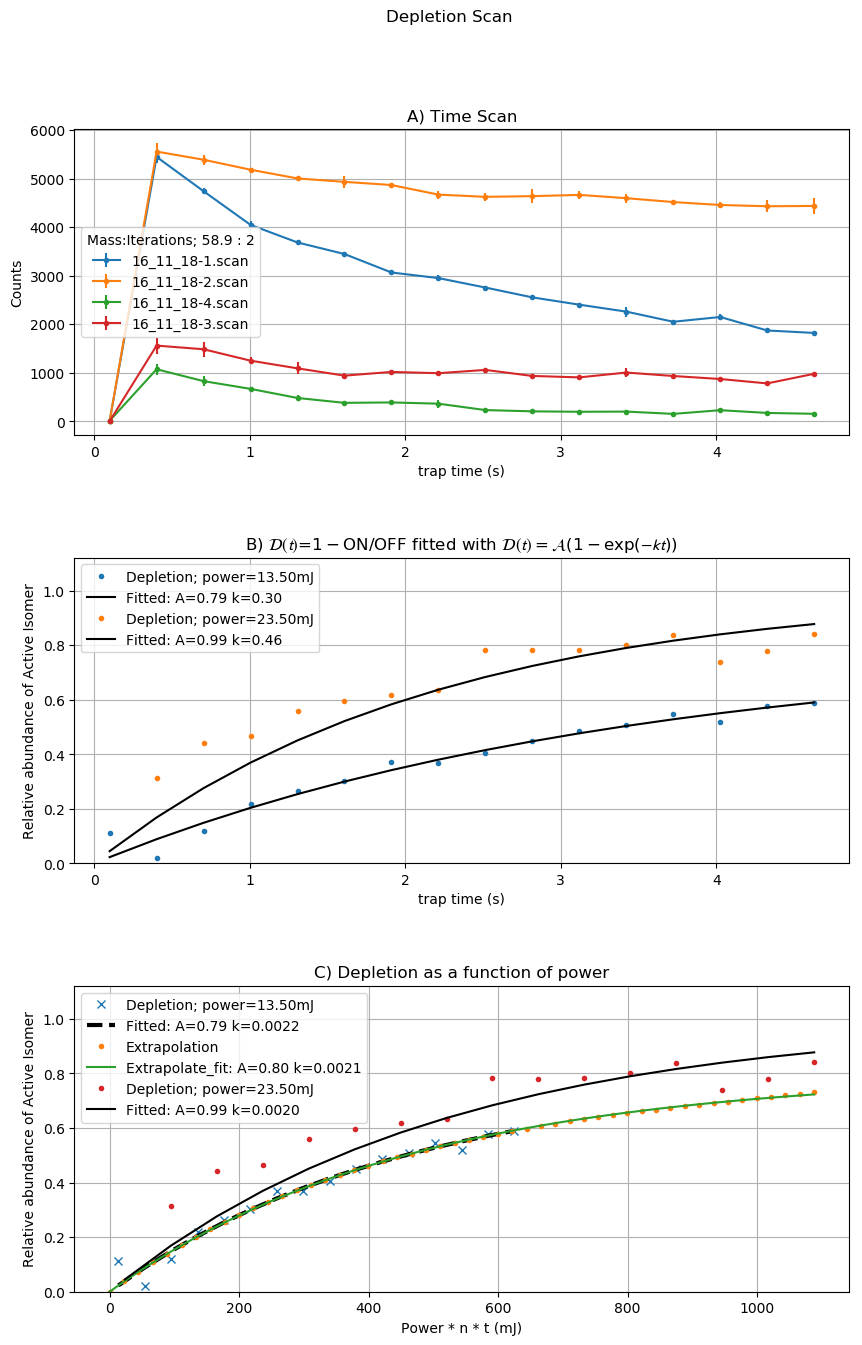

In [248]:
def depletionPlot(files, location, save, show, power_values):
    power_values = np.array(power_values)
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (10,15)
    plt.rcParams['figure.dpi'] = 100
    fig, axs = plt.subplots(3)
 
    graph = {}
    for i, ax in enumerate(axs.flat):
        graph['%i'%i] = ax    

    plt.subplots_adjust(top=0.9, hspace=0.4)
    plt.suptitle('Depletion Scan' ,fontsize=12)
    full = []
    
    for f in files:
        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        x, y = time, mean[0]
        
        graph['0'].errorbar(x, y,yerr=error[0], fmt='.-', label=f)

        full.append(y)    
    
    time = np.array(time)
    
    interp_range = time.max()*power_values.max()*10
    power_new = np.linspace(0, interp_range)
    
    for i, pw in zip(range(0, len(full), 2), power_values):
        
        depletion = (full[i+1]-full[i])/full[i+1]
        
        #depletion as a function of time
        pop, popc = curve_fit(func, time, depletion)
        y_fit = func(time, *pop)

        graph['1'].plot(time, depletion,'.', label = 'Depletion; power=%.2fmJ'%pw)
        graph['1'].plot(time, y_fit, 'k', label = 'Fitted: A=%.2f k=%.2f'%tuple(pop))
        
        #depletion as a function of power
        power = np.array(time*10*pw)
        
        pop1, popc1 = curve_fit(func, power, depletion,  p0=[0.01, 0.004])
        power_fit = func(power, *pop1)
        
        if power.max()>=interp_range:
            graph['2'].plot(power, depletion,'.', label = 'Depletion; power=%.2fmJ'%pw)
            graph['2'].plot(power, power_fit,'k',label = 'Fitted: A=%.2f k=%.4f'%tuple(pop1))
        
        if power.max()<interp_range:
            graph['2'].plot(power, depletion,'x', label = 'Depletion; power=%.2fmJ'%pw)
            graph['2'].plot(power, power_fit,'--k',lw=3,label = 'Fitted: A=%.2f k=%.4f'%tuple(pop1))
            
            interp_f = interp1d(power, power_fit, kind='cubic', bounds_error=False, fill_value='extrapolate')
            graph['2'].plot(power_new, interp_f(power_new),'.', label = 'Extrapolation')
            
            pop2, popc2 = curve_fit(func, power_new, interp_f(power_new),  p0=[0.01, 0.004])
            interp_fit = func(power_new, *pop2)
            
            graph['2'].plot(power_new, interp_fit,label = 'Extrapolate_fit: A=%.2f k=%.4f'%tuple(pop2))
    
    graph['0'].set_ylabel('Counts')
    graph['0'].legend(title='Mass:Iterations; %s : %s'%(mass[0], iterations[0]))
    graph['0'].set_xlabel('trap time (s)')
    graph['0'].set_title('A) Time Scan')
    
    graph['1'].set_ylim(ymin=0)
    graph['1'].set_xlabel('trap time (s)')
    graph['1'].set_ylabel('Relative abundance of Active Isomer')
    graph['1'].legend()
    graph['1'].set_title(r'B) $\mathcal{D(t)}$=$1-$ON/OFF fitted with $\mathcal{D(t)}=\mathcal{A}(1-\exp(\mathcal{-kt}))$')
    
    graph['2'].set_ylim(ymin=0)
    graph['2'].legend()
    graph['2'].set_xlabel('Power * n * t (mJ)')
    graph['2'].set_ylabel('Relative abundance of Active Isomer')
    graph['2'].set_title('C) Depletion as a function of power')
    
    for ax in axs.flat:
        ax.grid(True)
    
    if save: plt.savefig('depletion.png')
    if show: plt.show()
    plt.tight_layout()
    plt.close()

files = ['16_11_18-4.scan', '16_11_18-3.scan']
files1 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
files2 = ['16_11_18-1.scan', '16_11_18-2.scan']
depletionPlot(files1, location, save, show, power_values=(13.5, 23.5))

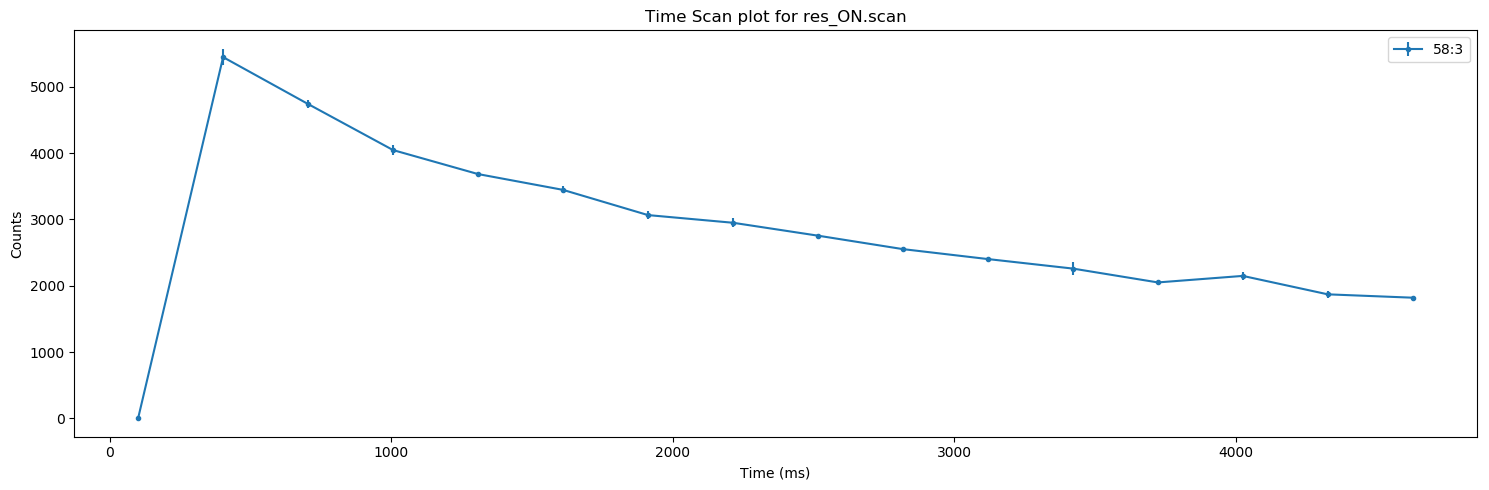

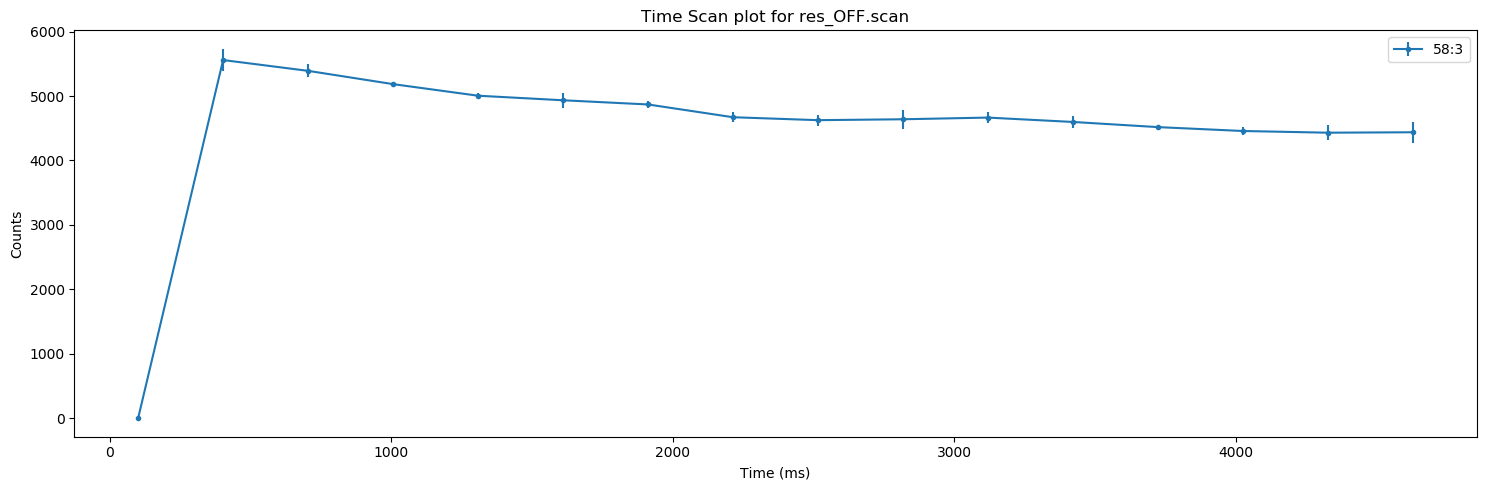

In [6]:
timescanplot('res_ON.scan', location, save, show)
timescanplot('res_OFF.scan', location, save, show)

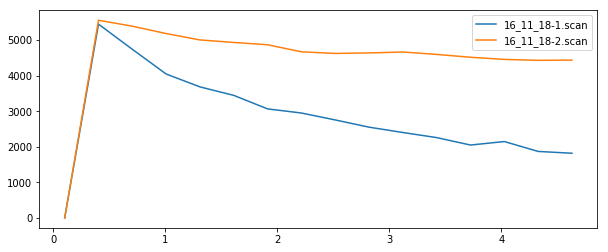

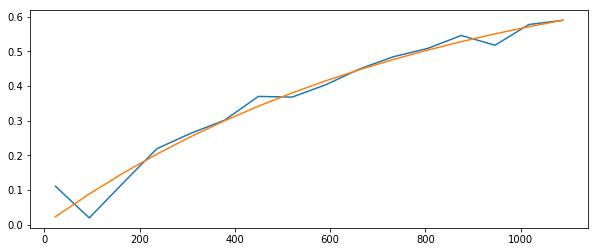

In [13]:
def func(power, A, k):
    return A*(1-np.exp(-k*power))

fl = ['16_11_18-1.scan', '16_11_18-2.scan']
plt.figure(figsize=(10,4))

dep = []
for f in fl:
    mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
    x, y = time/1000, mean[0]
    plt.plot(x, y, label=f)
    dep.append(y)
    
plt.legend()

depletion = 1- (dep[0]/dep[1])
plt.figure(figsize=(10,4))
time = time/1000
power = time*10*23.5

plt.plot(power, depletion)
pop, popc = curve_fit(func, time, depletion)
fit = func(time, *pop)
plt.plot(power, fit)

In [26]:
from scipy.misc import derivative as deriv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\scipy\misc\common.py:119: RuntimeWarning: invalid value encountered in multiply
  val += weights[k]*func(x0+(k-ho)*dx,*args)


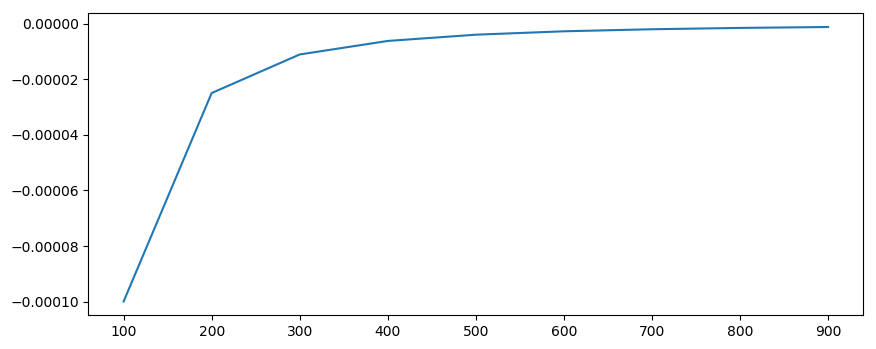

In [40]:

x = np.arange(0, 1000, 100)
y = lambda x: 1/x
y_deriv = deriv(y, x)
plt.figure(figsize=(10, 4))
#plt.plot(x, y(x))
plt.plot(x, y_deriv)

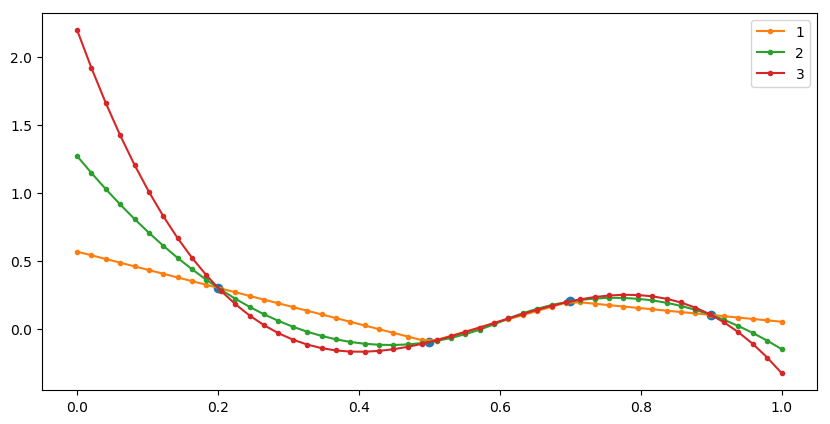

In [146]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

# given values
xi = np.array([0.2, 0.5, 0.7, 0.9])
yi = np.array([0.3, -0.1, 0.2, 0.1])

# positions to inter/extrapolate
x = np.linspace(0, 1, 50)

# spline order: 1 linear, 2 quadratic, 3 cubic ... 
order = 1

# do inter/extrapolation
s = InterpolatedUnivariateSpline(xi, yi, k=order)
y = s(x)

# example showing the interpolation for linear, quadratic and cubic interpolation
plt.figure(figsize=(10, 5))
plt.plot(xi, yi, 'o')

for order in range(1, 4):
    s = InterpolatedUnivariateSpline(xi, yi, k=order)
    y = s(x)
    plt.plot(x, y,'.-', label=order)
    
plt.legend()
plt.show()
plt.close()

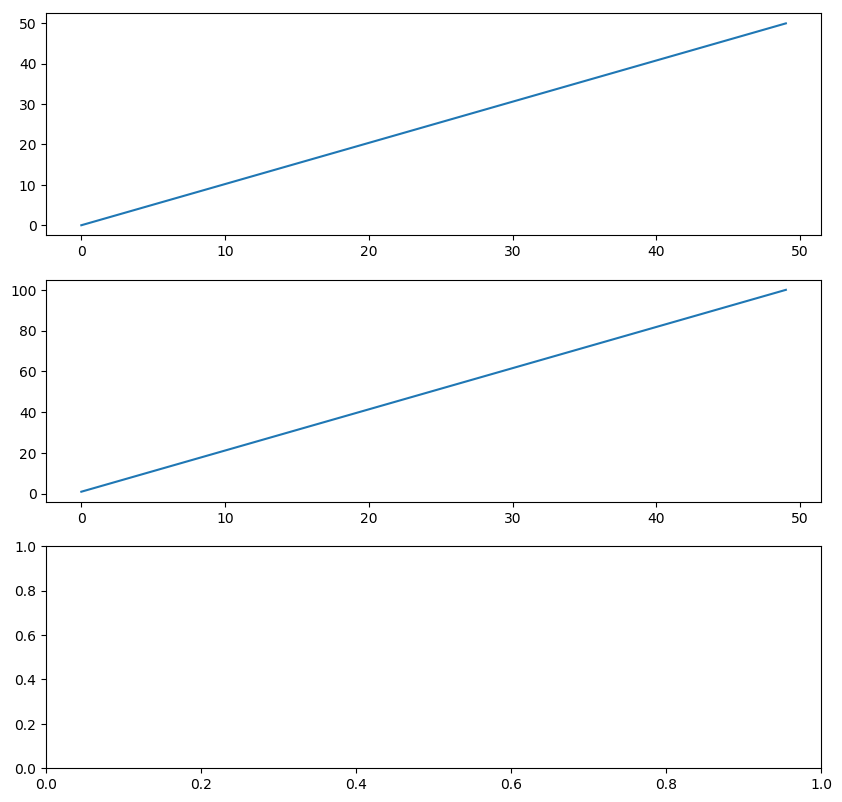

In [209]:
fig, axs = plt.subplots(3)
graph = {}
for i, j in enumerate(axs.flat):
    graph['%i'%i] = j 
    
graph['0'].plot(np.linspace(0,50))
graph['1'].plot(np.linspace(1,100))